In [178]:
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy.integrate as integrate

## Monday Week 1 (08/07/2024): Have to create a class for a bound mass profile
 - Look at https://github.com/LSSTDESC/CCL/blob/master/pyccl/halos/profiles/nfw.py as an example of the creation of a halo mass profile.
 - Python docs on classes: https://docs.python.org/3/tutorial/classes.html
 - Selected bits: 
   - the class inheritance mechanism allows multiple base classes
   - a derived class can override any methods of its base class or classes
   - a method can call the method of a base class with the same name

$\rho_X(r)\ = Ma ^{-3} f_X g_X(r)\$. 

- M = total halo mass
- $f_X$ = the fraction of that mass in gas species X
- $g(x)$ = the profile, which satisfies the normalisation $4\pi \int^{\infty}_0 dr\ r^2 g_X(r)\ = 1$
- a = the scale factor

$f_c + f_b + f_e + f_* = 1$ AND (assuming adiabaticity) $f_b + f_e + f_* = \bar{f}_b \equiv \frac{\Omega_b}{\Omega_M}$

----------------------------------------------------------------------------
In [paper](../Background-reading/XrayCrossCorrelations-1.pdf), see that:   
$\rho_x(r)\ = M f_x\ a^{-3} g_x(r)\ $    

$f_b(M) = []$   
$g_b(r)\ = \frac{1}{V_b} \left( \frac{log(1 + \frac{r}{r_s})}{\frac{r}{r_s}} \right)^{\frac{1}{\Gamma - 1}} $ , where $log \equiv ln$.    
$V_b \equiv 4\pi r_s^3 I_b(\frac{1}{\Gamma - 1}, 0)\ $   
$I_b(\gamma, q)\ = \int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\gamma} j_0(qx)\ $, with $ q = kr_s $ [in Fourier space].   
$\to I_b(\frac{1}{\Gamma - 1}, 0)\ = \int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\frac{1}{\Gamma - 1}} j_0(0)\  = \int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\frac{1}{\Gamma - 1}}$   
As $j_0 $ is a Besel function, & $j_0(0)\ = 1 $.

Therefore:   
$\rho_x(r)\ = \frac{M f_x\ }{4\pi r_s^3 a^{3}} \frac{1}{\int^{\infty}_0 dx\ x^2 \left( \frac{log(1+x)}{x} \right)^{\frac{1}{\Gamma - 1}}} \left( \frac{log(1 + \frac{r}{r_s})}{\frac{r}{r_s}} \right)^{\frac{1}{\Gamma - 1}} $ 

In [293]:
class boundGas_profile(ccl.halos.profiles.profile_base.HaloProfile): #(ccl.halos.Haloprofile):
    """Creating a class for the bound gas density profile
    where: """  # could put in the equations used

    def __init__(self, mass_def, r_s=1): # will change later, but can leave characteristic scale as ~ 1 Mpc for the moment
        self.r_s = r_s  # may need to add an rEj parameter into real & Fourier profiles below
        super(boundGas_profile, self).__init__(mass_def=mass_def)

    def _Vb1(self, gamma, rS=1):
        rS_use = np.atleast_1d(rS)
        gamma_use = np.atleast_1d(gamma)

        def innerInt(a, gam=1/(gamma-1), b=1, c=1):
            # may simplify back to just eqn = ...
            eqn = (1/c) * (a**2) * (np.log(1 + a/b)/(a/b))**gam
            return eqn
        
       # delete line: innerInt_solved
        vB1 = integrate.quad(innerInt, 0, np.inf) # go with default pars 1st
        # delete line: outerInt_solved = integrate.quad(innerInt, 0, np.inf, args=(1/(1-gamma_use), rS_use, innerInt_solved[0] * rS_use**3) ) 
                                         # args = gam, b, c
    # integrate.quad returns [y, abserr] (the integral, then the estimated absolute error, so have to index [0]
        # delete line: j0 = outerInt_solved[0]
       # delete line: # put in markdown above: Vb = 4 pi r_s^3 Ib(1/(gamma-1),0) = 4 pi * r_s^3 * j0 * innerInt_solved[0]
       # delete line: vB = 4*np.pi*(rS_use**3)*j0*innerInt_solved[0]
        vB2 = 4*np.pi*(rS_use**3)*vB1[0]
        return vB2

    def _real(self, r, M, gamma, r_s=1,
              a=1, f=1): # set the default pars for scale factor a & fraction of total mass f
        r_use = np.atleast_1d(r) # need them to be functional arrays
        M_use = np.atleast_1d(M)
        rS_use = np.atleast_1d(r_s)
        gamma_use = np.atleast_1d(gamma)

        # Returns: float or array_like: halo profile. The shape of the output will be `(N_M, N_r)` 
        # where `N_r` and `N_m` are the sizes of `r` and `M` respectively.

       # polydex = 1/(gamma_use - 1) # polytropic index
        vB = self._Vb1(gamma, r_s)[0]
        prefix = M_use * f * (1/a**3) * (1/vB)

        x = r[None, :] / rS_use[:, None]
        prof = prefix[:, None] * innerInt(x)

        if np.ndim(r) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)
                                                          
        return prof

    #### THEN DO FOURIER EQN!!!
    def _fourier(self, k, M, r_s, gamma,
                 a=1, f=1):
        k_use = np.atleast_1d(k)
        M_use = np.atleast_1d(M)
        rS_use = np.atleast_1d(r_s)

        prefix = M_use * f / a**3
        x = k[None, :] * rEj_use[:, None]
        # delete: prof = np.exp(-(1/2)*(r_use[None, :]/r_ej[:, None])**2)
        prof = prefix[:, None] * np.exp(-(x**2)/2)

        #prof = M_use * f * np.exp(-(1/2)*(k_use*r_ej)**2)/(a**3)

        if np.ndim(k) == 0:
            prof = np.squeeze(prof, axis=-1)
        if np.ndim(M) == 0:
            prof = np.squeeze(prof, axis=0)

        return prof
    

Characteristic scale $r_s$ should be ~ 1 Mpc (so leave as = 1), and gamma $\Gamma$ (which has no real physical significance, just a fitting number) should be around ~ 1.1-1.2 (but when doing normalisation interpolator, should do for $\Gamma \in [1.01,10]$ ).

In [296]:
# working with z = 0 (today) ; therefore a = 1
# use a mass definition with Delta = 200
hmd_200c = ccl.halos.MassDef200c
bd_rsTrial = 1
trial_bdProf = boundGas_profile(hmd_200c)#, bd_rsTrial) # (mass_def, r_s) (r_s = the characteristic scale)

In [302]:
trial_bdProf._Vb1(gamma=1.1)

array([0.66012243])

In [300]:
trial_r = np.geomspace(1E-2,1E8,100000) # geomspace is like linspace, but evenly spaces on a logscale
trial_M = np.array([5E12,2E13, 1E14])
trial_gamma = 1.1 # np.array([2,3,4])
profTrial_real = trial_bdProf._real(trial_r, trial_M, bd_rsTrial, trial_gamma)
# _real(self, r, M, r_s, gamma, a=1, f=1)
profTrial_real

ZeroDivisionError: division by zero

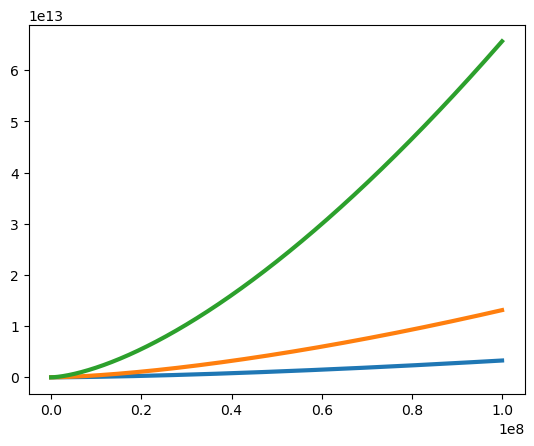

In [240]:
i=0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i], lw=3, zorder = i)
    i+=1

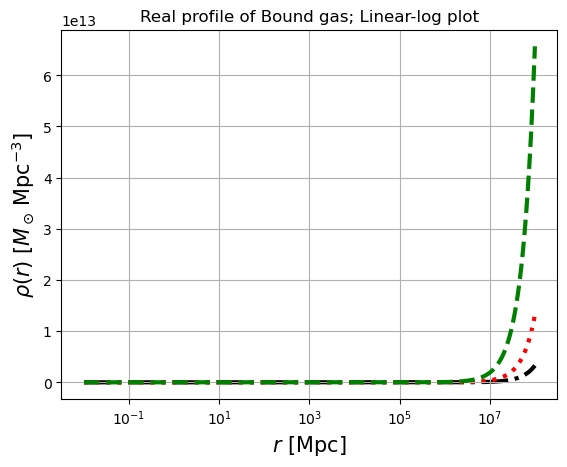

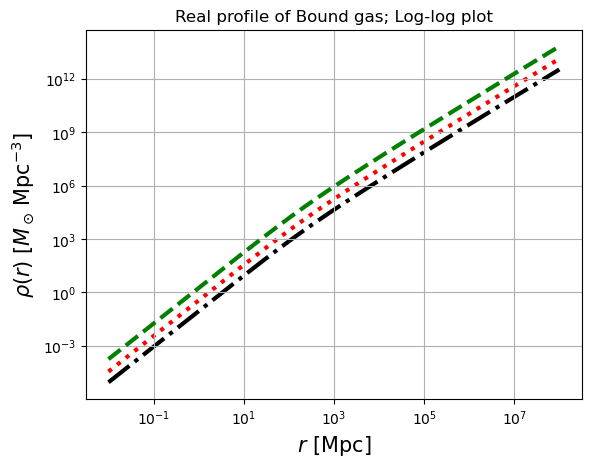

In [189]:
colours = ['k-.', 'r:', 'g--']
i = 0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i],
         colours[i], lw=3, zorder = i)
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('Real profile of Bound gas; Linear-log plot')
plt.grid(True)
plt.xscale('log');
#plt.xlim(1e-2,1e5);
#plt.ylim(1e-2,1e5);

plt.figure()
i = 0
for j in trial_M:
    plt.plot(trial_r, profTrial_real[i],
         colours[i], lw=3, zorder = i)
    i+=1
plt.ylabel(r'$\rho(r)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
plt.xlabel(r'$r\,\,[{\rm Mpc}]$', fontsize=15);
plt.title('Real profile of Bound gas; Log-log plot')
plt.grid(True)
plt.xscale('log');
plt.yscale('log');
#plt.xlim(1e-2,1e5);
#plt.ylim(1e-2,1e5);

# Fourier profile for the bound gas to be done ()

In [251]:
trial_k = np.geomspace(1E-20,1E2,100000)
trial_M = np.array([5E12,2E13, 1E14])
profTrial_fourier = trial_bdProf._fourier(trial_k, trial_M,  bd_rsTrial) # , 
profTrial_fourier

array([[5.e+12, 5.e+12, 5.e+12, ..., 0.e+00, 0.e+00, 0.e+00],
       [2.e+13, 2.e+13, 2.e+13, ..., 0.e+00, 0.e+00, 0.e+00],
       [1.e+14, 1.e+14, 1.e+14, ..., 0.e+00, 0.e+00, 0.e+00]])

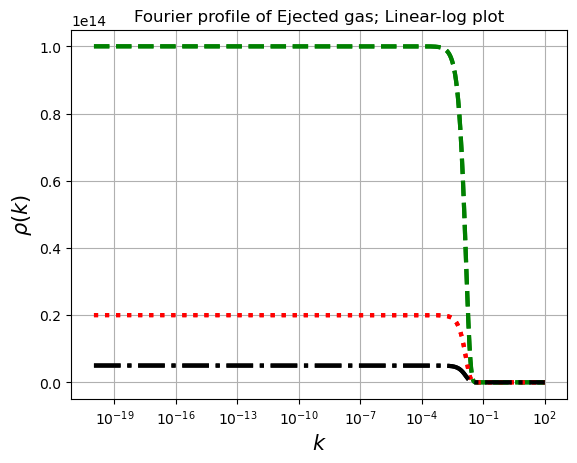

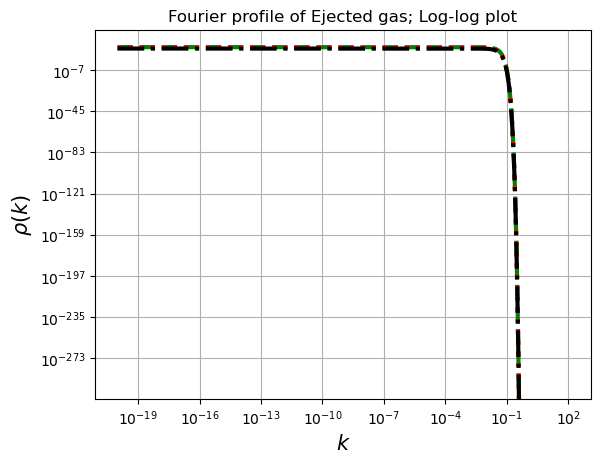

In [277]:
#### colours = ['k-.', 'r:', 'g--']
i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[i],
         colours[i], lw=3)
    i+=1
# plt.ylabel(r'$\rho(k)\,\,[M_\odot\,{\rm Mpc}^{-3}]$', fontsize=15)
# plt.xlabel(r'$k\,\,[{\rm Mpc}]$', fontsize=15);
plt.xscale('log');

i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[i],
         colours[i], lw=3, zorder = (10-i))
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', 
           fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', 
           fontsize=15);
plt.title('Fourier profile of Bound gas; Linear-log plot')
plt.grid(True)
plt.xscale('log');
plt.xlim(1e-5,1e2);
#plt.ylim(1e-5,1e2);

plt.figure()
i = 0
for j in trial_M:
    plt.plot(trial_k, profTrial_fourier[i],
         colours[i], lw=3, zorder = (10-i))
    i+=1
plt.ylabel(r'$\rho(k)\, \,[M_\odot\,{\rm Mpc}^{-3}]$', 
           fontsize=15)
plt.xlabel(r'$k\, \,[{\rm Mpc^{-1}}]$', 
           fontsize=15);
plt.title('Fourier profile of Bound gas; Log-log plot')
plt.grid(True)
plt.xscale('log');
plt.yscale('log');
plt.xlim(1e-5,1e2);
#plt.ylim(1e-5,1e2);